## Jonathan Alvarez - DATA 695 - Model Development
### 10-22-2023

In [173]:
#Import Dependencies
import pandas as pd
import numpy as np 

# data visualization
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style
import seaborn as sns

# Algorithms
from sklearn import decomposition, preprocessing
from sklearn.model_selection import train_test_split,cross_val_predict,StratifiedKFold, learning_curve
from sklearn.feature_selection import SelectFromModel,RFECV
from sklearn import linear_model, tree
from sklearn.linear_model import LogisticRegression,Perceptron,SGDClassifier,LassoCV
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score,recall_score,f1_score,confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
import tensorflow as tf
tf.config.run_functions_eagerly(True)
#from keras.wrappers.scikit_learn import KerasClassifier

data = pd.read_csv("C:/Users/jonal/OneDrive/Documents/FranklinU/DATA695/Pre-ML.csv")

def grouplabels(row):
    ''' This function is used to group labels into 3 classifications (Insufficient/Normal Weight | Overweight | Obese)  '''

    if row['NObeyesdad'] == 'Normal_Weight':
        return 'Normalweight'
    elif  row['NObeyesdad'] == 'Insufficient_Weight':
        return 'Normalweight' 
    elif 'Overweight' in row['NObeyesdad'] :
        return 'Overweight' 
    elif 'Obesity' in row['NObeyesdad']:
        return 'Obese'
    else:
        return row['NObeyesdad']
    

In [174]:
data['NObeyesdad'] = data.apply(grouplabels, axis=1)

In [175]:
pcadf = data.iloc[:,0:16]
dftarget = data.iloc[:,16:17]

# X -> features
# y -> label
X = pcadf
y = dftarget

(array([0, 1, 2]),
 [Text(0, 0, 'Normalweight'), Text(1, 0, 'Obese'), Text(2, 0, 'Overweight')])

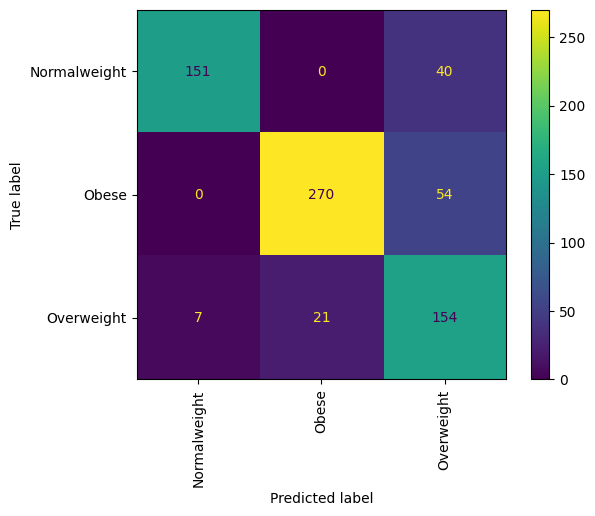

In [176]:
# dividing X, y into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 0)
  
# training a DescisionTreeClassifier
dtree_model = DecisionTreeClassifier(max_depth = 2).fit(X_train, y_train)
dtree_predictions = dtree_model.predict(X_test)
  
# creating a confusion matrix
cm = confusion_matrix(y_test, dtree_predictions)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,  display_labels=dtree_model.classes_)
disp.plot()
plt.xticks(rotation = 90)

In [73]:
# Print classification report due to having multiple classes
print(classification_report(y_test, dtree_predictions))

                     precision    recall  f1-score   support

Normal-Below_Weight       0.96      0.79      0.87       191
              Obese       0.93      0.83      0.88       324
         Overweight       0.62      0.85      0.72       182

           accuracy                           0.82       697
          macro avg       0.83      0.82      0.82       697
       weighted avg       0.86      0.82      0.83       697



c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(array([0, 1, 2]),
 [Text(0, 0, 'Normal-Below_Weight'),
  Text(1, 0, 'Obese'),
  Text(2, 0, 'Overweight')])

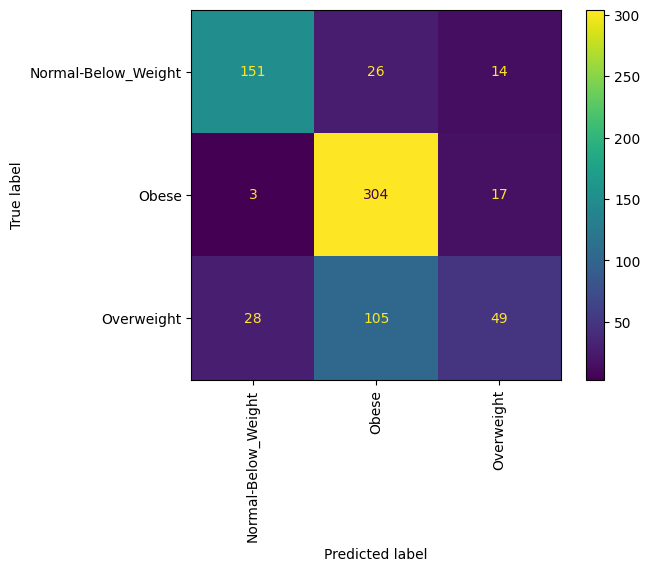

In [70]:
gnb = GaussianNB().fit(X_train, y_train)
gnb_predictions = gnb.predict(X_test)
  
 
# creating a confusion matrix
cm_nb = confusion_matrix(y_test, gnb_predictions)

nb_disp = ConfusionMatrixDisplay(confusion_matrix=cm_nb,  display_labels=gnb.classes_)
nb_disp.plot()
plt.xticks(rotation = 90)

In [71]:
print(classification_report(y_test, gnb_predictions))

                     precision    recall  f1-score   support

Normal-Below_Weight       0.83      0.79      0.81       191
              Obese       0.70      0.94      0.80       324
         Overweight       0.61      0.27      0.37       182

           accuracy                           0.72       697
          macro avg       0.71      0.67      0.66       697
       weighted avg       0.71      0.72      0.69       697



In [198]:
# Create model here
model = Sequential()
model.add(Dense(9, input_dim = 16, activation = 'relu')) # Rectified Linear Unit Activation Function
model.add(Dense(9, activation = 'relu'))
model.add(Dense(3, activation = 'softmax'))              # Softmax for multi-class classification
# Compile model here
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 9)                 153       
                                                                 
 dense_34 (Dense)            (None, 9)                 90        
                                                                 
 dense_35 (Dense)            (None, 3)                 30        
                                                                 
Total params: 273 (1.07 KB)
Trainable params: 273 (1.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [201]:
# Label Encode from strings
label_encoder = preprocessing.LabelEncoder()
yy = label_encoder.fit_transform( data['NObeyesdad'])
y['NObeyesdad'] = yy

# Using keras to categorical to ensure proper format
y_cat = to_categorical(y)
x_train, x_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.33, random_state = 0)

C:\Users\jonal\AppData\Local\Temp\ipykernel_2624\3691183883.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['NObeyesdad'] = yy


In [202]:
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=25, batch_size=25)

Epoch 1/25
10/57 [====>.........................] - ETA: 0s - loss: 1.6540 - accuracy: 0.1800

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


56/57 [============================>.] - ETA: 0s - loss: 1.2886 - accuracy: 0.2600

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


57/57 [==============================] - 1s 17ms/step - loss: 1.2861 - accuracy: 0.2624 - val_loss: 1.1081 - val_accuracy: 0.4060
Epoch 2/25
57/57 [==============================] - 1s 16ms/step - loss: 1.0681 - accuracy: 0.4519 - val_loss: 1.0177 - val_accuracy: 0.4892
Epoch 3/25
57/57 [==============================] - 1s 16ms/step - loss: 0.9774 - accuracy: 0.4859 - val_loss: 0.9353 - val_accuracy: 0.5022
Epoch 4/25
57/57 [==============================] - 1s 16ms/step - loss: 0.8843 - accuracy: 0.5467 - val_loss: 0.8243 - val_accuracy: 0.5983
Epoch 5/25
57/57 [==============================] - 1s 16ms/step - loss: 0.7612 - accuracy: 0.6238 - val_loss: 0.6764 - val_accuracy: 0.6714
Epoch 6/25
57/57 [==============================] - 1s 16ms/step - loss: 0.6211 - accuracy: 0.7001 - val_loss: 0.5930 - val_accuracy: 0.7360
Epoch 7/25
57/57 [==============================] - 1s 16ms/step - loss: 0.5497 - accuracy: 0.7567 - val_loss: 0.5483 - val_accuracy: 0.7518
Epoch 8/25
57/57 [======

22/22 [==============================] - 0s 2ms/step


c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


(array([0, 1, 2]), [Text(0, 0, '0'), Text(1, 0, '1'), Text(2, 0, '2')])

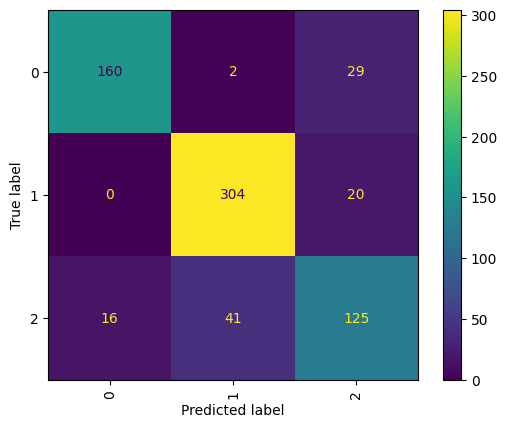

In [203]:
y_pred = model.predict(x_test)
y_test_class = np.argmax(y_test,axis=1)
y_pred_class = np.argmax(model.predict(x_test), axis=-1)

# creating a confusion matrix
cm_seq = confusion_matrix(y_test_class, y_pred_class)

seq_disp = ConfusionMatrixDisplay(confusion_matrix=cm_seq,  display_labels=np.unique(y_pred_class))
seq_disp.plot()
plt.xticks(rotation = 90)

In [204]:
print(classification_report(y_test_class, y_pred_class))

              precision    recall  f1-score   support

           0       0.91      0.84      0.87       191
           1       0.88      0.94      0.91       324
           2       0.72      0.69      0.70       182

    accuracy                           0.85       697
   macro avg       0.83      0.82      0.83       697
weighted avg       0.84      0.85      0.84       697

